# A notebook in R for modelling species distributions using the standard Maximum Entropy Model

In this notebook we will compute the Maximum Entropy model for predicting species distributions using presence-only data. This method has been the cannonical model in predicting species records that lack real absences. 
For achiving this we will use the R package maxnet (cite article 2017, black box), an *Open Source* version of the MaxEnt java application used in earlier studies (Philips, et.al 2006).

The MaxEnt model requires three data sources: i) environmental (covariates), ii) occurrence records (species presence) and ii) background sample (independent environmental locations).
For the purposes of this comparison we will use the same background sample as in the Presence-only models (CAR). 

## Caveats
The MaxEnt model is a pointwise model

No smapling bias , taken all data



In [39]:
library(dplyr)
library(purrr)
library(biospytial.rwrapper)
#install.packages('maxnet')
library(maxnet)

In [40]:
## Read adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]
# Convert to numeric
TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

names(TDF)[23] <- 'covid2'
DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Plantae,LUCA),
                              species=pseudo_absence_naive(Pinophyta,Plantae))
                    
                    
formula_sample=sample~Disttoroadm+Populationm #+factor(tipos)
formula_presence=species~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)

burnin = 50000
n.sample = 100000
thin = 50    

In [46]:
predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame)
maxentm = maxnet(TDF$Pinophyta,predictors,maxnet.formula(TDF$Pinophyta,predictors,classes='l'))
pred_vals = predict(maxentm,predictors,type='cloglog')


## K-fold cross validation

In [48]:
## Make ROC curve
library(pROC)
library('caret')
validate = createFolds(y = TDF$Pinophyta, k=7, returnTrain = FALSE)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [49]:
l <- list()
i = 1
for (fold in validate) {
    
    predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame[fold])
    
    maxentm = maxnet(TDF$Pinophyta[fold],predictors,maxnet.formula(TDF$Pinophyta[fold],predictors,classes='l'))
    
    pred_vals = predict(maxentm,predictors,type='cloglog')
    
    
    observed.presences <- DataFrame$species[fold]
    ## Substitue by NA
    DataFrame$species[fold] <- NA
    results  <- joint.binomial.bymCARModel1(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE) 

    DataFrame$species <- DataFrame$presences
    ## Return original values
    DataFrame$predicted_values_CV[fold] <- results$fitted.values[fold]
    predicted.probability = results$fitted.values[fold]
    pROC_obj <- roc(observed.presences,predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

$Fold1
  [1]   19   36   51   55   56   58   70   73   74   76   81   83   92  107  110
 [16]  116  121  139  148  154  163  166  175  192  194  195  201  202  205  206
 [31]  216  221  245  247  248  253  271  276  280  294  301  309  311  329  332
 [46]  340  352  355  365  368  378  390  405  423  431  436  441  453  463  475
 [61]  479  486  487  496  509  518  521  530  537  538  566  569  584  585  591
 [76]  592  599  616  617  629  646  651  655  658  662  664  677  682  684  685
 [91]  691  698  699  710  718  721  746  766  776  787  791  807  816  820  821
[106]  833  834  841  845  853  855  857  885  889  903  906  911  913  919  920
[121]  921  939  943  946  953  957  965  976  977  980  984  985  995  997 1009
[136] 1010 1015 1017 1018 1034 1035 1037 1040 1046 1053 1061 1065 1081 1084 1101
[151] 1103 1109 1113 1116 1117 1127 1133 1141 1142 1146 1148 1151 1155 1160 1165
[166] 1180 1188 1198 1200 1204 1206 1211 1215 1218 1229 1231 1242 1243 1247 1252
[181] 1262 1266 1273 1274 1282 1287 1298 1299 1300 1303 1304 1312 1317 1318 1332
[196] 1337 1341 1363 1367 1381 1384 1396 1402 1407 1408 1413 1420 1435 1443 1458
[211] 1459 1465 1467 1482 1493 1504 1513 1519 1522 1524 1532 1536 1538 1542 1551
[226] 1557 1558 1564 1580 1583 1586 1615 1628 1638 1655 1659 1660 1667 1668 1673
[241] 1676 1702 1708 1710 1716 1731 1737 1747 1754 1755 1778 1789 1801 1802 1823
[256] 1827 1828 1830 1845 1847 1852 1862 1864 1877 1884 1896 1898 1906 1913 1943
[271] 1947 1951 1955 1963 1965 1966 1969 1971 1973 1975 2028 2040 2042 2043 2051
[286] 2062 2067 2069 2070 2071 2073 2074 2082 2084 2089 2092 2093 2102 2103 2104
[301] 2113 2114 2130 2135 2143 2145 2150 2185 2191 2198 2201 2210 2217 2219 2221
[316] 2222 2224 2227 2229 2237 2251 2252 2261 2266 2272 2273 2275 2279 2282 2297
[331] 2315 2318 2319 2341 2343 2346 2347 2348 2352 2358 2360 2363 2371 2387 2389
[346] 2412 2420 2432 2435 2436 2448 2450 2452 2465 2466 2468 2475 2490 2494 2502
[361] 2505 2508 2512 2533 2535 2547 2554 2556 2559 2563 2568 2582 2586 2590 2591
[376] 2598 2600 2603 2609 2622 2623 2624 2630 2648 2652 2656 2674 2676 2683 2695
[391] 2699 2701 2719 2720 2733 2736 2740 2742 2770 2774 2780 2784 2791 2800 2813
[406] 2825 2826 2828 2831 2836 2844 2874 2878 2880 2881 2911 2912 2913 2923 2928
[421] 2931 2936 2947 2949 2951 2961 2976 2977 2981 2983 2989 2995 2996 3002 3004
[436] 3005 3009 3015 3033 3034 3038 3049 3054 3063 3089 3096 3100 3101 3125 3127
[451] 3133 3146 3150 3152 3163 3186 3190 3193 3196 3205 3218 3219 3220 3227 3235
[466] 3238 3243 3245 3256 3261 3266 3275 3282 3301 3307 3317 3344 3347 3369 3372
[481] 3385 3390 3392 3396 3402 3430 3431 3436 3441 3442 3444 3459 3474 3475 3496
[496] 3497 3503 3510 3524 3527 3529 3534 3537 3539 3540 3546 3548 3576 3581 3584
[511] 3596 3600 3601 3612 3613 3629 3639 3641 3649 3655 3661 3662 3677 3678 3693
[526] 3725 3728 3732 3744 3748 3749 3757 3760 3768 3774 3783 3786 3788 3792 3794
[541] 3796 3797 3798 3822 3823 3825 3827 3833 3845 3880 3882 3884 3888 3893 3900
[556] 3907 3922 3934 3938 3947 3951 3955 3956 3966 3975 3982 3983 3995 4007 4008
[571] 4013 4026 4035 4038 4039 4042 4046 4053 4059 4060

$Fold2
  [1]    4   13   15   16   27   29   32   34   39   40   53   60   75  112  125
 [16]  130  133  135  136  138  140  149  150  151  153  164  169  170  177  183
 [31]  199  215  217  225  226  233  272  278  279  302  316  333  334  337  347
 [46]  348  349  362  370  377  398  403  407  410  414  418  427  445  447  451
 [61]  452  472  476  477  489  493  495  505  513  533  539  543  546  548  558
 [76]  560  565  579  595  598  600  601  605  609  622  625  656  672  676  679
 [91]  683  688  693  696  714  724  729  736  739  745  750  754  774  775  786
[106]  806  808  811  818  823  825  826  827  829  830  840  844  860  863  864
[121]  874  875  876  882  886  891  894  897  900  905  909  931  935  936  940
[136]  952  963  968  978  987 1001 1005 1008 1025 1041 1043 1052 1074 1082 1100
[151] 1102 1111 1118 1119 1121 1124 1131 

In [45]:

## Save to posterity
chain = cbind(TDF$cellids,pred_vals)
colnames(chain) <- c("cellids", "maxentPines")
file_ = '/outputs/presence_only_models/maxent_pines2.csv'

write.csv(chain,file_)

## Here put the evaluations code

In [125]:
install.packages('sdm')

Warning message in install.packages("sdm"):
“installation of package ‘sdm’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [124]:
library('sdm')

ERROR: Error in library("sdm"): there is no package called ‘sdm’


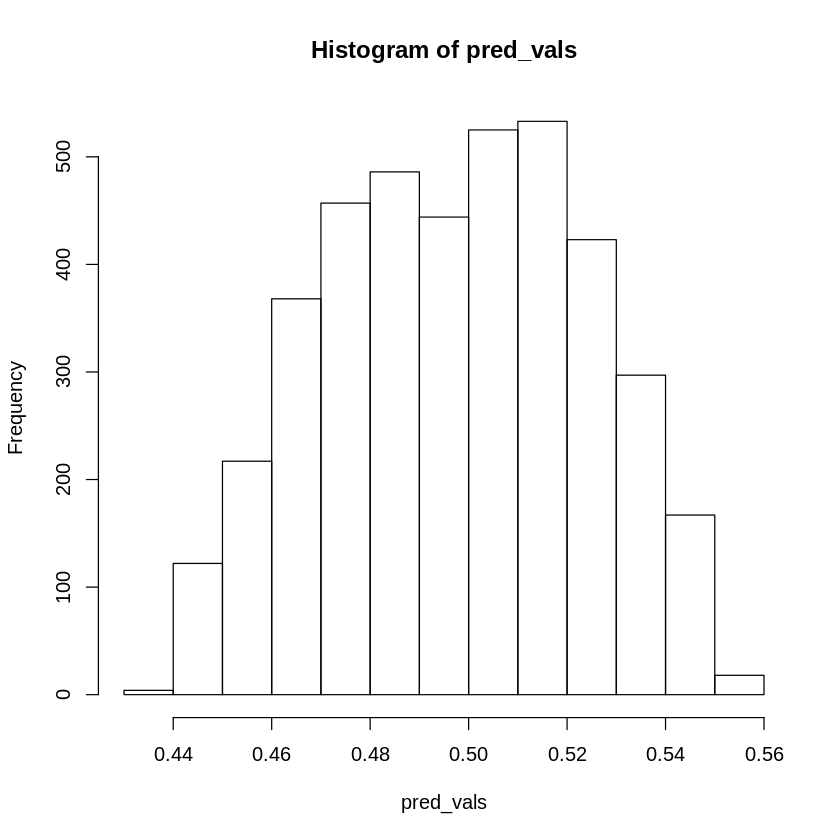

In [89]:
hist(pred_vals)

In [83]:
summary(me_mod)

               Length Class     Mode     
a0             200    -none-    numeric  
beta           400    dgCMatrix S4       
df             200    -none-    numeric  
dim              2    -none-    numeric  
lambda         200    -none-    numeric  
dev.ratio      200    -none-    numeric  
nulldev          1    -none-    numeric  
npasses          1    -none-    numeric  
jerr             1    -none-    numeric  
offset           1    -none-    logical  
classnames       2    -none-    character
call             8    -none-    call     
nobs             1    -none-    numeric  
betas            2    -none-    numeric  
alpha            1    -none-    numeric  
entropy          1    -none-    numeric  
penalty.factor   2    -none-    numeric  
featuremins      2    -none-    numeric  
featuremaxs      2    -none-    numeric  
varmin           2    -none-    numeric  
varmax           2    -none-    numeric  
samplemeans      2    -none-    list     
levels           2    -none-    li

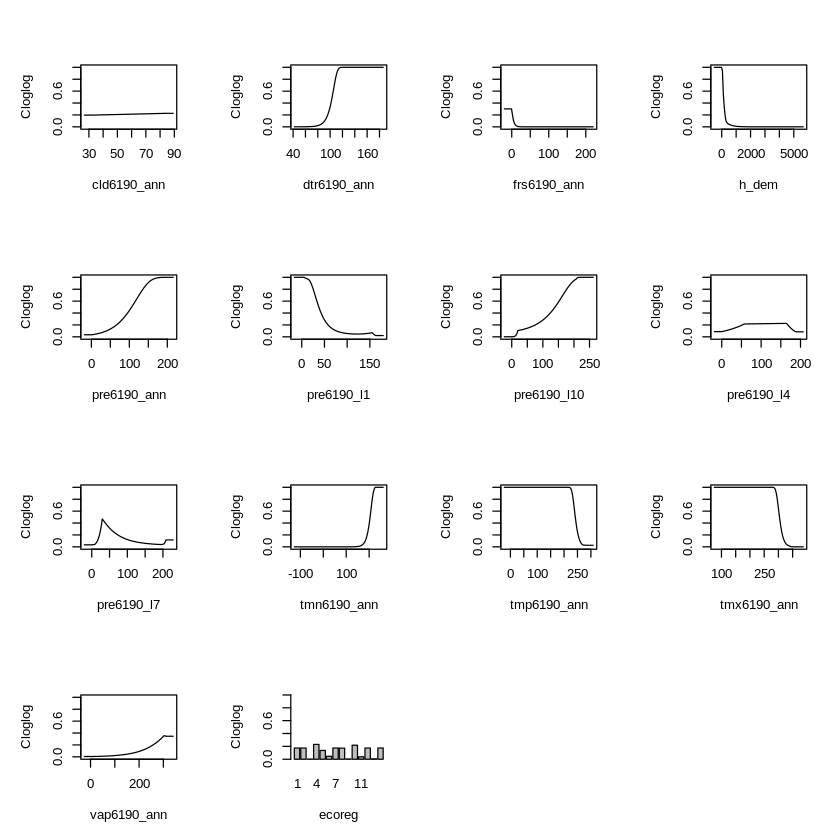

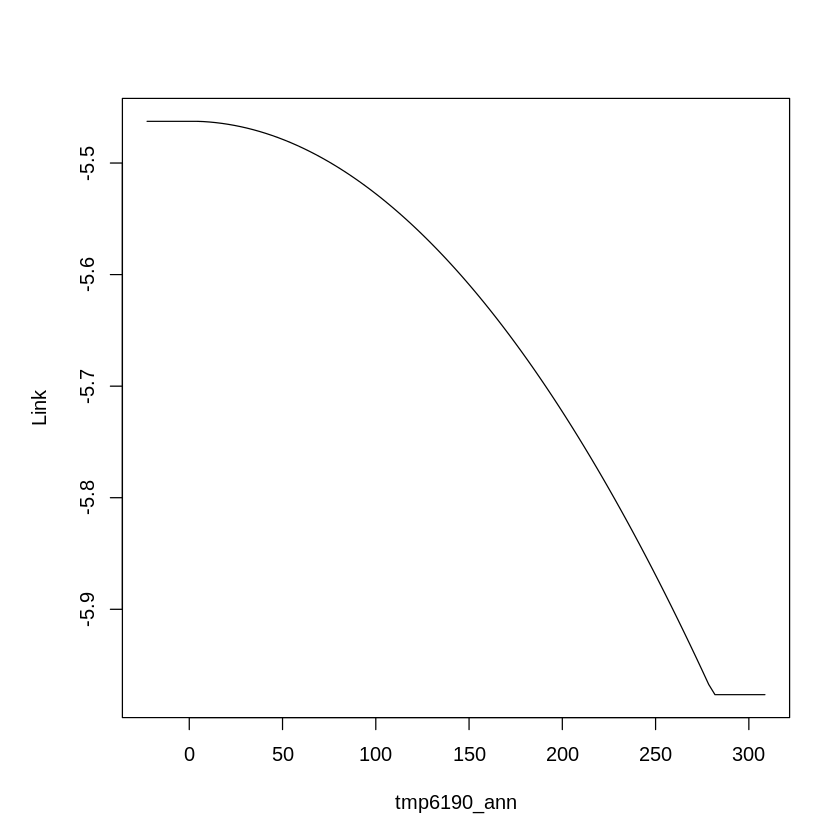

In [22]:
data(bradypus)
p <- bradypus$presence
data <- bradypus[,-1]
mod <- maxnet(p, data)
plot(mod, type="cloglog")
mod <- maxnet(p, data, maxnet.formula(p, data, classes="lq"))
plot(mod, "tmp6190_ann")

In [24]:
bradypus

presence,cld6190_ann,dtr6190_ann,ecoreg,frs6190_ann,h_dem,pre6190_ann,pre6190_l1,pre6190_l10,pre6190_l4,pre6190_l7,tmn6190_ann,tmp6190_ann,tmx6190_ann,vap6190_ann
1,76,104,10,2,121,46,84,41,54,3,192,266,337,279
1,76,104,10,2,121,46,84,40,54,3,192,266,337,279
1,57,114,10,1,211,65,129,56,58,34,140,244,321,221
1,57,112,10,3,363,36,71,33,27,13,135,229,307,202
1,57,113,10,3,303,39,77,35,29,15,134,229,306,202
1,58,111,10,0,166,54,107,48,45,23,156,252,326,235
1,57,110,8,0,430,33,61,30,29,15,153,245,326,217
1,77,82,10,0,12,60,69,24,96,42,229,275,335,306
1,83,86,10,0,23,58,96,30,95,25,220,271,328,301
1,82,85,10,0,32,62,84,39,98,29,224,272,328,300


In [37]:
maxnet.formula(presences,predictors,classes="l")

~sample + Disttoroadm + Populationm - 1
<environment: 0x7f15e4a7b6c0>

In [38]:
names(data)

[1] "cld6190_ann" "dtr6190_ann" "ecoreg"      "frs6190_ann" "h_dem"      
 [6] "pre6190_ann" "pre6190_l1"  "pre6190_l10" "pre6190_l4"  "pre6190_l7" 
[11] "tmn6190_ann" "tmp6190_ann" "tmx6190_ann" "vap6190_ann"

In [25]:
subset(TDF, select=-Pinophyta)

X,LUCA,Plantae,Abies,cellids,Disttoroadm,Elevationm,MaxTempm,MeanTempm,MinTempm,⋯,WindSpm,Longitude,Latitude,wwfmhtnum,wwfmhtnam,covid,name,covid2,tipos,geometry
632,0,0,0,233546,277,3029,2353,2264,1990,⋯,799,-97.65156,21.46739,1,Tropical and Subtropical Moist Broadleaf Forests,42818,PASTIZAL CULTIVADO,8020,Selva Alta Perennifolia,POINT (-97.651563416 21.467389801)
3609,1,1,0,233547,2556,1133,2332,2330,1971,⋯,885,-97.60256,21.46739,1,Tropical and Subtropical Moist Broadleaf Forests,114294,VEGETACIÓN SECUNDARIA ARBÓREA DE SELVA MEDIANA SUBPERENNIFOLIA,8020,Selva Alta Perennifolia,POINT (-97.602563416 21.467389801)
2780,1,1,0,233548,3242,4,2305,2387,1956,⋯,885,-97.55356,21.46739,NA,NaN,24618,NO EMPATA,NA,NaN,POINT (-97.553563416 21.467389801)
1488,0,0,0,233549,204,2,2194,3095,3197,⋯,1050,-97.50456,21.46739,14,Mangroves,87982,MANGLAR,NA,NaN,POINT (-97.504563416 21.467389801)
415,0,0,0,233550,553,5,2113,2274,1765,⋯,885,-97.45556,21.46739,NA,NaN,24618,NO EMPATA,NA,NaN,POINT (-97.455563416 21.467389801)
3888,1,0,0,233551,906,9,2127,2274,1781,⋯,885,-97.40656,21.46739,14,Mangroves,24618,NO EMPATA,8045,Pastizal Cultivado,POINT (-97.406563416 21.467389801)
2057,1,0,0,233552,1120,1409,2150,2274,1801,⋯,885,-97.36443,21.46926,14,Mangroves,42560,PASTIZAL CULTIVADO,7812,Pastizal Cultivado,POINT (-97.3644320579 21.469261601)
2277,0,0,0,233553,3392,3630,4052,3095,3197,⋯,1050,-97.22934,21.47248,NA,NaN,17499,SIN VEGETACIÓN APARENTE,NA,NaN,POINT (-97.2293390727 21.4724816044)
421,0,0,0,233747,279,3320,2643,2406,2174,⋯,440,-97.79856,21.41839,1,Tropical and Subtropical Moist Broadleaf Forests,73992,AGRICULTURA DE TEMPORAL ANUAL,7291,Pastizal Cultivado,POINT (-97.79856341599999 21.418389801)
3367,1,1,0,233748,197,3349,2485,2328,2069,⋯,512,-97.74956,21.41839,1,Tropical and Subtropical Moist Broadleaf Forests,42818,PASTIZAL CULTIVADO,7291,Pastizal Cultivado,POINT (-97.749563416 21.418389801)


In [4]:
model.sample <-S.CARbym(formula=formula_sample,family="binomial",W=M_bis,trials = trials,data=DataFrame,burnin=burnin,n.sample=n.sample,thin=thin,verbose = TRUE)

Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  846.8 seconds.


In [5]:
model.presence <- S.CARbym(formula=formula_presence,family="binomial",W=M_bis,trials = trials,data=DataFrame,burnin=burnin,n.sample=n.sample,thin=thin,verbose = TRUE)

Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  866.1 seconds.


In [6]:
#DIC for model with polygon 4 611.3458
print(model.sample)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - sample ~ Disttoroadm + Populationm
Number of missing observations - 731

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept)  3.5183  2.8552  4.5571     1000     46.3        17.8         0.6
Disttoroadm -0.0002 -0.0004 -0.0001     1000     46.3       530.0         1.0
Populationm  0.0000 -0.0001  0.0002     1000     46.3      1000.0        -0.1
tau2         6.6524  3.7867 11.9560     1000    100.0        26.7        -0.1
sigma2       0.4145  0.0551  3.3149     1000    100.0         5.0         1.0

DIC =  2092.947       p.d =  543.3697       LMPL =  -1111.51 


In [7]:
print(model.presence)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - species ~ Elevationm + MeanTempm
Number of missing observations - 1161

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept) -4.4071 -6.1465 -3.1003     1000     46.5        32.6         1.7
Elevationm   0.0002 -0.0001  0.0005     1000     46.5       701.9         1.0
MeanTempm   -0.0007 -0.0012 -0.0002     1000     46.5       297.3         0.6
tau2        14.7050  7.1535 31.7971     1000    100.0        12.6        -1.4
sigma2       0.0930  0.0331  0.4415     1000    100.0         9.1        -0.9

DIC =  1420.211       p.d =  441.4069       LMPL =  -786.85 


In [8]:
## Compute independent joint distribution
library(boot)
## Calculate the inverse of the logit for extracted fitted 
#fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,inv.logit)
#fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,inv.logit)

fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,identity)
fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,identity)

re_presence = apply(model.presence$samples$psi,MARGIN=1,identity)
re_sample = apply(model.sample$samples$psi,MARGIN=1,identity)

In [9]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}



In [10]:
## Sample from the posterior
sample.y <- data.frame(t(fitted_presences)) %>% mutate_all(function(p) rbernoulli(1,p))
sample.x <- data.frame(t(fitted_sample)) %>% mutate_all(function(p) rbernoulli(1,p))
sum.x <- colSums(sample.x)
nsample <- nrow(sample.x)
PX <- sum.x / nsample
sum.y <- colSums(sample.y)
PY <- sum.y / nsample
PXY <- PX * PY

In [11]:
P = getUpperLowerCI(fitted_presences,prefix = 'P')
S = getUpperLowerCI(fitted_sample,prefix = 'S')
Gp = getUpperLowerCI(re_presence,prefix = 'Gp')
Gs = getUpperLowerCI(re_sample,prefix = 'Gs')

In [12]:
dataout = cbind(TDF$cellids,P,S,Gp,Gs,PX,PY,PXY)

In [13]:
## Save the complete chain trace for analysing in Python,
file_ = '/outputs/presence_only_models/modelCAR1.csv'
write.csv(dataout,file_)

### Postprocess the posterior dist.

In [ ]:
joint_ind_ps_summary = getUpperLowerCI(joint_ind_ps,prefix='join_ind_ps',MARGIN=1)

In [ ]:
var_joint_ind_ps_summary = getUpperLowerCI(var_joint_ind_ps,prefix='var_joint',MARGIN=1)

In [ ]:
sample_ci = getUpperLowerCI(model.sample$samples$fitted,prefix = 'sample')

In [ ]:
presence_ci = getUpperLowerCI(model.presence$samples$fitted,prefix='pinophyta')

In [ ]:
#TDF$fitted_values = model.spatial$fitted.values
#TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary,sample_ci,presence_ci)
TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary)


In [ ]:
## Export to CSV
write.csv(TDF,file='/outputs/resultsCAR_sampleeffort1_puebla_p9_pinophyta_luca.csv')

In [ ]:
HASTA AQUI ME QUEDE HOY. FALTA VER que pasa con los modelos hacer mapa

In [ ]:
dtau = density(model.presence$samples$tau2)
dsigma = density(model.presence$samples$sigma2)

plot(dtau,main=expression(tau^2))
plot(dsigma,main=expression(sigma^2))
plot(beta1,main="Intercept")
plot(beta2,main="Distance to Road")
plot(beta3,main="Population")

In [ ]:
mod_sig = glm(formula, data=TDF, family=binomial())
#mod1.summary()

In [ ]:
summary(mod_sig)

In [ ]:
confint(mod_sig)

## Instantiate Geospatial data

In [ ]:
library(lattice)
library(sp)


In [ ]:
coordinates(TDF) <- c("Longitude","Latitude")

In [ ]:
bubble(TDF,"Pinophyta")

## Spatial analysis in R
First, exploratory

In [ ]:
library(gstat)

In [ ]:
plot(variogram(Pinophyta ~ 1,TDF))

In [ ]:
install.packages("geoR")

In [ ]:
install.packages("geoRglm")

In [ ]:
library('spdep')

In [ ]:
model_car = spautolm(Pinophyta ~ Dist.to.road_m +  Population_m + tipos,data=TDF,family="CAR")